In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pathlib import Path
import pandas as pd

# Load newest cleaned CSV relative to this notebook
nb_dir = Path.cwd()  # when run from notebook, this should be tests/single_shot_tests
csv_dir = nb_dir / "data" / "stance_converted"
candidates = sorted(csv_dir.glob("cleaned_pairs_*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
if not candidates:
    raise FileNotFoundError(f"No cleaned_pairs_*.csv found in {csv_dir}")
file_path = str(candidates[2])
print("Using:", file_path)

df = pd.read_csv(file_path)

Using: /home/sammli/llm-network/tests/single_shot_tests/data/stance_converted/cleaned_pairs_20260206-020727.csv


In [3]:
# Ensure numeric types + pick best semantic similarity column
preferred_semantic = "in_out_similarity_openai" if "in_out_similarity_openai" in df.columns else None
fallback_semantic = "in_out_similarity_sbert" if "in_out_similarity_sbert" in df.columns else None
semantic_col = preferred_semantic or fallback_semantic
if semantic_col is None:
    raise KeyError("Expected in_out_similarity_openai or in_out_similarity_sbert in CSV")

# If OpenAI column exists but is entirely missing, fall back to SBERT
if preferred_semantic and df[preferred_semantic].isna().all() and fallback_semantic:
    semantic_col = fallback_semantic
print("Semantic similarity column:", semantic_col)

numeric_cols = [
    "stance_weight",  # may exist but no longer used as ground-truth
    "input_stance_score",
    "output_stance_score",
    "input_topic_similarity",
    "output_topic_similarity",
    "input_strength",
    "output_strength",
    semantic_col,
    # (keep these if present)
    "in_out_similarity_openai",
    "in_out_similarity_sbert",
 ]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Use embedder-derived initial opinion as the target, not the hand-assigned stance_weight
target_col = "input_stance_score"
if target_col not in df.columns:
    raise KeyError(f"Expected {target_col} in CSV")

# Drop rows needed for the requested plots / model fit
df = df.dropna(subset=[target_col, "output_stance_score", semantic_col])

print("Rows:", len(df))

# Fit affine calibration: o_hat = a^T x + b, x=[similarity, stance]
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df[[semantic_col, "output_stance_score"]].to_numpy(dtype=float)
y = df[target_col].to_numpy(dtype=float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin = LinearRegression()
lin.fit(X_train, y_train)
y_hat = lin.predict(X)
y_hat_test = lin.predict(X_test)

df["calibrated_opinion"] = y_hat
a = lin.coef_.astype(float)
b = float(lin.intercept_)
print("Affine map: o_hat = a^T[s, stance] + b")
print("a:", a, "b:", b)
print("Train R^2:", float(lin.score(X_train, y_train)))
print("Test R^2:", float(r2_score(y_test, y_hat_test)))
print("Test MSE:", float(mean_squared_error(y_test, y_hat_test)))

print(f"Corr({target_col}, output_stance_score):", df[target_col].corr(df["output_stance_score"]))
print(f"Corr({target_col}, {semantic_col}):", df[target_col].corr(df[semantic_col]))
print(f"Corr({target_col}, calibrated_opinion):", df[target_col].corr(df["calibrated_opinion"]))

Semantic similarity column: in_out_similarity_openai
Rows: 300
Affine map: o_hat = a^T[s, stance] + b
a: [-1.10957428  0.63625162] b: 0.7319645697892152
Train R^2: 0.4928617350415988
Test R^2: 0.22529770711117925
Test MSE: 0.0787036804156831
Corr(input_stance_score, output_stance_score): 0.640886238219711
Corr(input_stance_score, in_out_similarity_openai): -0.21892659454722108
Corr(input_stance_score, calibrated_opinion): 0.6668258372988883


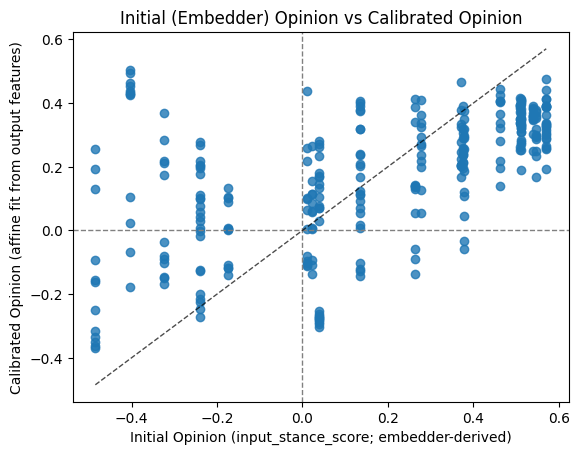

In [4]:
plt.figure()
plt.scatter(df["input_stance_score"], df["calibrated_opinion"], alpha=0.8)
plt.xlabel("Initial Opinion (input_stance_score; embedder-derived)")
plt.ylabel("Calibrated Opinion (affine fit from output features)")
plt.title("Initial (Embedder) Opinion vs Calibrated Opinion")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.axvline(0.0, linestyle="--", linewidth=1, color="gray")
# Reference line y=x
xmin, xmax = float(df["input_stance_score"].min()), float(df["input_stance_score"].max())
plt.plot([xmin, xmax], [xmin, xmax], linestyle="--", linewidth=1, color="black", alpha=0.7)
plt.show()

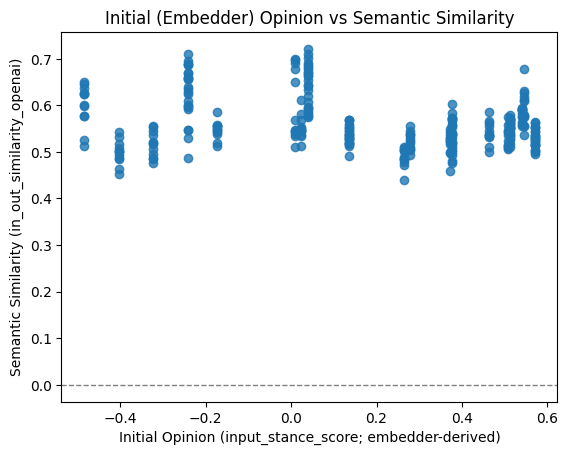

In [4]:
plt.figure()
plt.scatter(df["input_stance_score"], df[semantic_col], alpha=0.8)
plt.xlabel("Initial Opinion (input_stance_score; embedder-derived)")
plt.ylabel(f"Semantic Similarity ({semantic_col})")
plt.title("Initial (Embedder) Opinion vs Semantic Similarity")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()

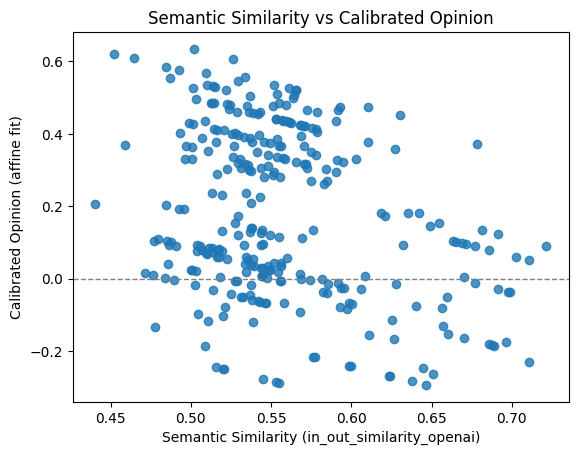

In [5]:
plt.figure()
plt.scatter(df[semantic_col], df["calibrated_opinion"], alpha=0.8)
plt.xlabel(f"Semantic Similarity ({semantic_col})")
plt.ylabel("Calibrated Opinion (affine fit)")
plt.title("Semantic Similarity vs Calibrated Opinion")
plt.axhline(0.0, linestyle="--", linewidth=1, color="gray")
plt.show()